<a href="https://colab.research.google.com/github/zhihong1224/CNN_Demo/blob/master/hw12_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Domain Adaption

# Data Introduce

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
ROOT='gdrive/My Drive/Colab Notebooks/Hongyi_Li/data'
# Download dataset
!gdown --id '12-07DSquGdzN3JBHBChN4nMo3i8BqTiL' --output real_or_drawing.zip
# Unzip the files
!unzip real_or_drawing.zip

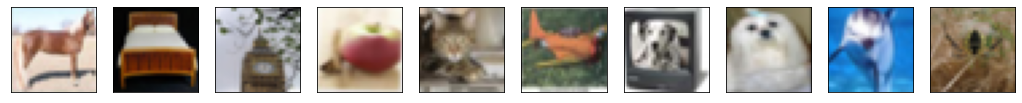

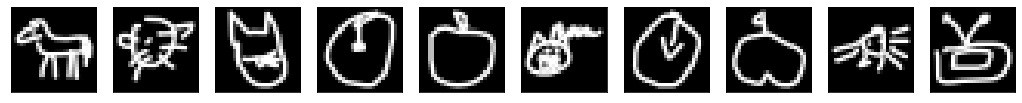

In [0]:
import os
import numpy as np
import torch
from torch import nn,optim
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def show_img(root):
  titles=['horse','bed','clock','apple','cat','plane','television','dog','dolphin','spider']
  plt.figure(figsize=(18,18))
  imgs=[]
  if root.split('/')[-1].split('_')[0]=='train':
    for i in range(10):
      filename=os.path.join(root,str(i)+'/'+str(500*i)+'.bmp')
      imgs.append(Image.open(filename))
  else:
    for i in range(10):
      filename=os.path.join(root,'0/'+str(i).rjust(5,'0')+'.bmp')
      imgs.append(Image.open(filename))
  for i,img in enumerate(imgs):
    plt.subplot(1,10,i+1)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
train_root='./real_or_drawing/train_data'
test_root='./real_or_drawing/test_data'
show_img(train_root)
show_img(test_root)

In [0]:
a=Image.open(os.path.join(test_root,'0/'+str(1).rjust(5,'0')+'.bmp'))
np.array(a).shape

(28, 28, 3)

# Special Domain Knowledge

([], <a list of 0 Text major ticklabel objects>)

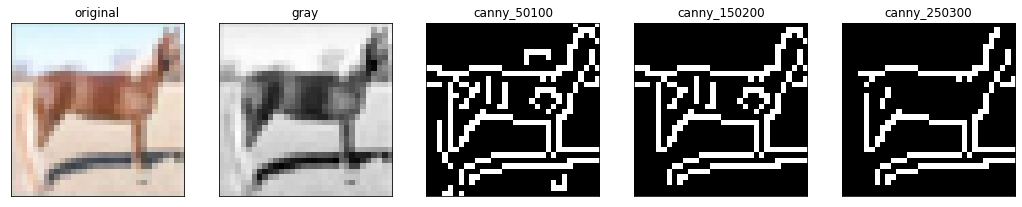

In [0]:
import cv2
plt.figure(figsize=(18,18))
original_img='real_or_drawing/train_data/0/0.bmp'
plt.subplot(1,5,1)
plt.imshow(Image.open(original_img))
plt.title('original')
plt.xticks([])
plt.yticks([])

gray_img=cv2.cvtColor(cv2.imread(original_img),cv2.COLOR_BGR2GRAY)
plt.subplot(1,5,2)
plt.imshow(gray_img,cmap='gray')
plt.title('gray')
plt.xticks([])
plt.yticks([])

canny_50100=cv2.Canny(gray_img,50,100)
plt.subplot(1,5,3)
plt.imshow(canny_50100,cmap='gray')
plt.title('canny_50100')
plt.xticks([])
plt.yticks([])

canny_150200=cv2.Canny(gray_img,150,200)
plt.subplot(1,5,4)
plt.imshow(canny_150200,cmap='gray')
plt.title('canny_150200')
plt.xticks([])
plt.yticks([])

canny_250300=cv2.Canny(gray_img,250,300)
plt.subplot(1,5,5)
plt.imshow(canny_250300,cmap='gray')
plt.title('canny_250300')
plt.xticks([])
plt.yticks([])

# Data Process

In [0]:
import torch.nn.functional as F
from torch.autograd import Function
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

source_trnsform=transforms.Compose([
  transforms.Grayscale(),
  transforms.Lambda(lambda x:cv2.Canny(np.array(x),170,300)),
  transforms.ToPILImage(),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15,fill=(0,)),
  transforms.ToTensor()
])
target_transform=transforms.Compose([
  transforms.Grayscale(),
  transforms.Resize((32,32)),
  transforms.RandomHorizontalFlip(),
  transforms.RandomRotation(15,fill=(0,)),
  transforms.ToTensor()
])

source_dataset=ImageFolder('real_or_drawing/train_data',transform=source_trnsform)
target_dataset=ImageFolder('real_or_drawing/test_data',transform=target_transform)

source_dataloader=DataLoader(source_dataset,batch_size=32,shuffle=True,num_workers=4)
target_dataloader=DataLoader(target_dataset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader=DataLoader(target_dataset,batch_size=128,shuffle=False,num_workers=4)

In [0]:
for X,Y in source_dataloader:
  print(X.shape,Y.shape)
  break
for X,_ in target_dataloader:
  print(X.shape)
  break

torch.Size([32, 1, 32, 32]) torch.Size([32])
torch.Size([32, 1, 32, 32])


# Model
> Feature extractor:VGG      
> Label Predictor/Domain Classifier:MLP

In [0]:
class FeatureExtractor(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
      nn.Conv2d(1,64,3,1,1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(64,128,3,1,1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(128,256,3,1,1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(256,256,3,1,1),
      nn.BatchNorm2d(256),
      nn.ReLU(),
      nn.MaxPool2d(2),

      nn.Conv2d(256,512,3,1,1),
      nn.BatchNorm2d(512),
      nn.ReLU(),
      nn.MaxPool2d(2)    # 512*1*1
    )

  def forward(self,x):
    x=self.conv(x).squeeze()
    return x

class LabelPredictor(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer=nn.Sequential(
      nn.Linear(512,512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.ReLU(),

      nn.Linear(512,10)
    )

  def forward(self,x):
    c=self.layer(x)
    return c

class DomainClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer=nn.Sequential(
      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,512),
      nn.BatchNorm1d(512),
      nn.ReLU(),

      nn.Linear(512,1)
    )

  def forward(self,x):
    x=self.layer(x)
    return x

# Pre-processing

In [0]:
feature_extractor=FeatureExtractor().cuda()
label_predictor=LabelPredictor().cuda()
domain_classifier=DomainClassifier().cuda()

class_criterion=nn.CrossEntropyLoss()
domain_criterion=nn.BCEWithLogitsLoss()

optimizer_F=optim.Adam(feature_extractor.parameters())
optimizer_C=optim.Adam(label_predictor.parameters())
optimizer_D=optim.Adam(domain_classifier.parameters())

# Train

In [0]:
def train_epoch(source_dataloader,target_dataloader,lamb):
  running_D_loss,running_F_loss=0.,0.
  total_hit,total_num=0.,0.

  for i,((source_data,source_label),(target_data,_)) in enumerate(zip(source_dataloader,target_dataloader)):
    source_data=source_data.cuda()
    source_label=source_label.cuda()
    target_data=target_data.cuda()

    mixed_data=torch.cat([source_data,target_data],dim=0)
    domain_label=torch.zeros([source_data.shape[0]+target_data.shape[0],1]).cuda()
    domain_label[:source_data.shape[0]]=1

    # 训练域分类器
    feature=feature_extractor(mixed_data)
    domain_logits=domain_classifier(feature.detach())
    loss=domain_criterion(domain_logits,domain_label)
    running_D_loss+=loss.item()
    optimizer_D.zero_grad()
    loss.backward()
    optimizer_D.step()

    # 训练特征提取器和分类器
    class_logits=label_predictor(feature[:source_data.shape[0]])
    domain_logits=domain_classifier(feature)
    loss=class_criterion(class_logits,source_label)-lamb*domain_criterion(domain_logits,domain_label)
    running_F_loss+=loss.item()
    optimizer_F.zero_grad()
    optimizer_C.zero_grad()
    loss.backward()
    optimizer_F.step()
    optimizer_C.step()

    total_hit+=torch.sum(torch.argmax(class_logits,dim=1)==source_label).item()
    total_num+=source_data.shape[0]
    print(i,end='\r')
  return running_D_loss/(i+1),running_F_loss/(i+1),total_hit/total_num
  
# 训练200 epochs
for epoch in range(200):
  train_D_loss,train_F_loss,train_acc=train_epoch(source_dataloader,target_dataloader,lamb=0.1)
  torch.save(feature_extractor.state_dict(),f'extractor_model.bin')
  torch.save(label_predictor.state_dict(),f'predictor_model.bin')
  print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f},\
     acc: {:6.4f}'.format(epoch,train_D_loss,train_F_loss,train_acc))


epoch   0: train D loss: 0.5426, train F loss: 1.2991,          acc: 0.5244
epoch   1: train D loss: 0.5465, train F loss: 1.2658,          acc: 0.5420
epoch   2: train D loss: 0.5479, train F loss: 1.2032,          acc: 0.5572
epoch   3: train D loss: 0.5394, train F loss: 1.1754,          acc: 0.5762
epoch   4: train D loss: 0.5419, train F loss: 1.1396,          acc: 0.5818
epoch   5: train D loss: 0.5365, train F loss: 1.1001,          acc: 0.5970
epoch   6: train D loss: 0.5232, train F loss: 1.0835,          acc: 0.6038
epoch   7: train D loss: 0.5219, train F loss: 1.0458,          acc: 0.6216
epoch   8: train D loss: 0.5358, train F loss: 0.9982,          acc: 0.6346
epoch   9: train D loss: 0.5294, train F loss: 0.9959,          acc: 0.6360
epoch  10: train D loss: 0.5147, train F loss: 0.9386,          acc: 0.6496
epoch  11: train D loss: 0.5057, train F loss: 0.9255,          acc: 0.6562
epoch  12: train D loss: 0.5187, train F loss: 0.8588,          acc: 0.6832
epoch  13: t

In [0]:
label_predictor.eval()
feature_extractor.eval()
result=[]
for i,(test_data,_) in enumerate(test_dataloader):
  test_data=test_data.cuda()
  class_logits=label_predictor(feature_extractor(test_data))
  x=torch.argmax(class_logits,dim=1).cpu().detach().numpy()
  result.append(x)

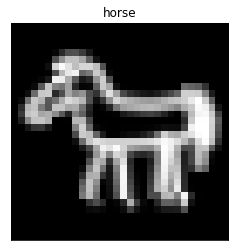

In [0]:
titles=['horse','bed','clock','apple','cat','plane','television','dog','dolphin','spider']
for test_da,_ in test_dataloader:
  test_data=test_da.cpu().detach().numpy()
  plt.imshow(test_data[0].squeeze(),cmap='gray')
  plt.title(titles[result[0][0]])
  plt.xticks([])
  plt.yticks([])
  break

# 2 Fine-tune

In [0]:
import numpy as np
import os
import torch
from torch import nn,optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models,datasets
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import glob
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt

In [10]:
DATA_ROOT='gdrive/My Drive/Colab Notebooks/data/flower_photos/flower_photos'
os.listdir(DATA_ROOT)

['tulips', 'daisy', 'dandelion', 'sunflowers', 'roses']

## 读取数据（法一）

In [15]:
trans=transforms.Compose([
  transforms.RandomResizedCrop(224),
  transforms.ToTensor(),
  transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])   # 这里到底需不需要均值和方差
])
train_data_all=datasets.ImageFolder(DATA_ROOT,trans)
print(len(train_data_all))
train_data_all[0]

3670


(tensor([[[ 0.4851,  0.5364,  0.5364,  ...,  0.6906,  0.6906,  0.6906],
          [ 0.5022,  0.5707,  0.5364,  ...,  0.7077,  0.6392,  0.5707],
          [ 0.4679,  0.5193,  0.5193,  ...,  0.7248,  0.6392,  0.5878],
          ...,
          [ 0.0227,  0.0569, -0.0287,  ...,  0.2453,  0.1939,  0.1768],
          [-0.0116, -0.0287, -0.0801,  ...,  0.3138,  0.2282,  0.1768],
          [-0.0458, -0.0801, -0.0458,  ...,  0.3652,  0.2796,  0.1939]],
 
         [[ 0.6078,  0.6779,  0.6779,  ...,  0.8354,  0.8354,  0.8354],
          [ 0.6429,  0.6954,  0.6604,  ...,  0.8529,  0.7829,  0.7129],
          [ 0.5903,  0.6429,  0.6429,  ...,  0.8704,  0.7829,  0.7304],
          ...,
          [ 0.1527,  0.1877,  0.1001,  ...,  0.3627,  0.3277,  0.3102],
          [ 0.1176,  0.1001,  0.0476,  ...,  0.4328,  0.3627,  0.3102],
          [ 0.0826,  0.0301,  0.0651,  ...,  0.4853,  0.4153,  0.3277]],
 
         [[ 0.9145,  0.8971,  0.9319,  ...,  1.0365,  1.0539,  1.0888],
          [ 0.8971,  0.9842,

In [0]:
batch_size=64
train_portion=0.8
train_num=int(train_portion*len(train_data_all))
indices=np.random.permutation(len(train_data_all))
train_sampler=SubsetRandomSampler(indices[:train_num])
valid_sampler=SubsetRandomSampler(indices[train_num:])
train_iter=DataLoader(train_data_all,batch_size=batch_size,sampler=train_sampler,num_workers=4)
valid_iter=DataLoader(train_data_all,batch_size=batch_size,sampler=valid_sampler,num_workers=4)

In [23]:
for X,Y in valid_iter:
  print(X.shape,Y.shape)
  break

torch.Size([64, 3, 224, 224]) torch.Size([64])


## 读取数据（法二）

In [29]:
images=glob.glob(DATA_ROOT+'/*/*')
print(len(images))
images[0]

3670


'gdrive/My Drive/Colab Notebooks/data/flower_photos/flower_photos/tulips/17165583356_38cb1f231d_n.jpg'

In [0]:
class Mydataset(Dataset):
  def __init__(self,images,trans):
    self.images=images
    self.trans=trans
  def __len__(self):
    return len(self.images)
  def __getitem__(self,item):
    titles={'tulips':0, 'daisy':1, 'dandelion':2, 'sunflowers':3, 'roses':4}
    img=Image.open(self.images[item])
    torch_img=self.trans(img)
    label=titles[self.images[item].split('/')[-2]]
    return torch_img,torch.tensor(label)

In [35]:
my_dataset=Mydataset(images,trans)
print(len(my_dataset))
# my_dataset[0]

3670


In [0]:
indcies=np.random.permutation(len(my_dataset))
train_sampler=SubsetRandomSampler(indices[:train_num])
valid_sampler=SubsetRandomSampler(indices[train_num:])
train_iter=DataLoader(my_dataset,batch_size=batch_size,sampler=train_sampler,num_workers=4)
valid_iter=DataLoader(my_dataset,batch_size=batch_size,sampler=valid_sampler,num_workers=4)

In [37]:
for X,Y in valid_iter:
  print(X.shape,Y.shape)
  break

torch.Size([64, 3, 224, 224]) torch.Size([64])


## 图像显示

In [0]:
def show(data_iter,show_num=batch_size):
  import math
  classes=['tulips', 'daisy', 'dandelion', 'sunflowers', 'roses']
  show_iter=iter(data_iter)
  show_data=next(show_iter)
  rows=math.ceil(math.sqrt(show_num))
  cols=math.ceil(show_num/rows)
  fig=plt.figure()
  img,label=show_data
  trans=transforms.Compose([
    transforms.Normalize([0,0,0.],[1/0.229,1/0.224,1/0.225]),
    transforms.Normalize([-0.485,-0.456,-0.406],[1,1,1.]),
    transforms.ToPILImage(),
  ])

  for i in range(show_num):
    ax=fig.add_subplot(rows,cols,i+1,xticks=[],yticks=[])
    ax.imshow(trans(img[i]))
    ax.set_title(classes[label[i].item()])

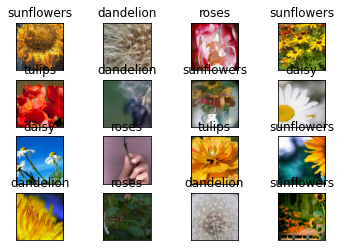

In [128]:
show(valid_iter,16)

## 模型

In [0]:
model=models.vgg16(pretrained=True)

In [0]:
model.classifier[6]=nn.Linear(4096,5)

In [71]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
# 微调1 特征提取器
for param in model.features.parameters():
  param.requires_grad=False

## 训练

In [0]:
def evaluate_acc(data_iter,model):
  model.eval()
  acc,n=0.,0
  with torch.no_grad():
    for X,Y in data_iter:
      X=X.cuda()
      Y=Y.cuda()
      y_pred=model(X)
      acc+=(y_pred.argmax(dim=1)==Y).sum()
      n+=Y.shape[0]
  model.train()
  return acc/n
def train(model,num_epochs,lr,train_iter,valid_iter,optimizer):
  model=model.cuda()
  criterion=nn.CrossEntropyLoss()


  for epoch in range(num_epochs):
    train_loss,train_acc,valid_loss,valid_acc,n,nv=0.,0.,0.,0.,0,0
    for X,Y in train_iter:
      X=X.cuda()
      Y=Y.cuda()
      y_pred=model(X)
      loss=criterion(y_pred,Y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss+=loss.item()*Y.shape[0]
      # train_acc+=(y_pred.argmax(dim=1)==Y).sum()
      n+=Y.shape[0]
      print('Epoch:{},Train loss:{}'.format(epoch,train_loss/n))

    model.eval()
    with torch.no_grad():
      for X,Y in valid_iter:
        X=X.cuda()
        Y=Y.cuda()
        y_pred=model(X)
        loss=criterion(y_pred,Y)
        valid_loss+=loss.item()*Y.shape[0]
        # valid_acc+=(y_pred.argmax(dim=1)==Y).sum()
        nv+=Y.shape[0]
      print('Valid loss:{}'.format(valid_loss/nv))
    model.train()

    train_acc=evaluate_acc(train_iter,model) 
    valid_acc=evaluate_acc(valid_iter,model)
    print()
    print('train loss:{},valid loss:{},train acc:{},valid acc:{}'\
  .format(train_loss/len(train_iter.sampler),valid_loss/len(valid_iter.sampler),train_acc,valid_acc))

In [0]:
num_epochs,lr=1,0.001

In [121]:
model=models.vgg16(pretrained=True)
model.classifier[6]=nn.Linear(4096,5)
# 微调1 特征提取器
for param in model.features.parameters():
  param.requires_grad=False
optimizer=optim.Adam(model.parameters(),lr=lr)
train(model,num_epochs,lr,train_iter,valid_iter,optimizer)

Epoch:0,Train loss:1.7628073692321777
Epoch:0,Train loss:1.7379693984985352
Epoch:0,Train loss:1.7531816164652507
Epoch:0,Train loss:1.8482866883277893
Epoch:0,Train loss:1.6784570693969727
Epoch:0,Train loss:1.5580492913722992
Epoch:0,Train loss:1.5002354298319136
Epoch:0,Train loss:1.4160895124077797
Epoch:0,Train loss:1.3451224366823833
Epoch:0,Train loss:1.2716242969036102
Epoch:0,Train loss:1.2090263691815464
Epoch:0,Train loss:1.1801072557767232
Epoch:0,Train loss:1.1702560461484468
Epoch:0,Train loss:1.124580259834017
Epoch:0,Train loss:1.123969296614329
Epoch:0,Train loss:1.10134669393301
Epoch:0,Train loss:1.0772527736776016
Epoch:0,Train loss:1.07053119275305
Epoch:0,Train loss:1.049821725017146
Epoch:0,Train loss:1.0293494701385497
Epoch:0,Train loss:1.0588569527580625
Epoch:0,Train loss:1.0717571865428577
Epoch:0,Train loss:1.064948709114738
Epoch:0,Train loss:1.0680796404679616
Epoch:0,Train loss:1.0710802316665649
Epoch:0,Train loss:1.0768399330285878
Epoch:0,Train loss:1

In [122]:
import gc
gc.collect()

1483

In [123]:
# 微调，设置不同的学习率
model=models.vgg16(pretrained=True)
model.classifier[6]=nn.Linear(4096,5)
finetuned_parameters=list(map(id,model.classifier.parameters()))
conv_parameters=(p for p in model.parameters() if id(p) not in finetuned_parameters)
parameters=[{'params':conv_parameters,'lr':1e-4},
      {'params':model.classifier.parameters()}]
optimizer=optim.Adam(parameters,lr=0.001)
train(model,num_epochs,lr,train_iter,valid_iter,optimizer)

Epoch:0,Train loss:1.7689077854156494
Epoch:0,Train loss:1.5112104415893555
Epoch:0,Train loss:1.3455819288889568
Epoch:0,Train loss:1.397921085357666
Epoch:0,Train loss:1.4747445344924928
Epoch:0,Train loss:1.4893961548805237
Epoch:0,Train loss:1.5372415951320104
Epoch:0,Train loss:1.4701525419950485
Epoch:0,Train loss:1.4351154963175456
Epoch:0,Train loss:1.389115959405899
Epoch:0,Train loss:1.3543285077268428
Epoch:0,Train loss:1.3134588648875554
Epoch:0,Train loss:1.277803673194005
Epoch:0,Train loss:1.23750501871109
Epoch:0,Train loss:1.2001532316207886
Epoch:0,Train loss:1.186882846057415
Epoch:0,Train loss:1.1487921546487248
Epoch:0,Train loss:1.1335080299112532
Epoch:0,Train loss:1.0980995297431946
Epoch:0,Train loss:1.0786759465932847
Epoch:0,Train loss:1.070166636080969
Epoch:0,Train loss:1.0442800494757565
Epoch:0,Train loss:1.0170882681141729
Epoch:0,Train loss:1.0102725426355998
Epoch:0,Train loss:1.0031286644935609
Epoch:0,Train loss:0.9976545824454381
Epoch:0,Train loss: